In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import float32

from sklearn.feature_selection import SelectKBest,chi2
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
tf.random.set_seed(42)

warnings.filterwarnings("ignore", category=UserWarning)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
dataset = pd.read_csv("business.csv")
dataset.head()
dataset.shape
dataset.isnull().sum()
dataset.dtypes
dataset["date"] = pd.to_datetime(dataset["date"], format='mixed')
dataset["month"] = dataset["date"].dt.month
dataset["year"] = dataset["date"].dt.year
dataset["day"] = dataset["date"].dt.day
dataset["dayofweek"] = dataset["date"].dt.dayofweek
dataset.columns
dataset.duplicated().sum()
dataset.shape

(93487, 15)

In [3]:
for data in dataset.columns:
    if dataset[data].dtype == "object":
        dataset[data] = dataset[data].astype(str)
        dataset[data] = dataset[data].str.strip()


In [4]:
for data in dataset.columns:
    if dataset[data].dtype == "object":
        print(dataset[data].groupby(dataset[data]).count().sort_values(ascending=False))
dataset["stop"] = dataset["stop"].str.replace("\n", "").str.replace("\t", "")
dataset["stop"] = dataset["stop"].str.strip()
dataset["stop"] = dataset["stop"].str.replace("stopVia", "stop Via")

airline
Vistara      60589
Air India    32898
Name: airline, dtype: int64
ch_code
UK    60589
AI    32898
Name: ch_code, dtype: int64
dep_time
07:00    3805
10:25    3560
09:45    2477
19:00    2450
20:35    2226
         ... 
22:40       7
12:40       6
05:35       4
19:35       2
14:50       1
Name: dep_time, Length: 166, dtype: int64
from
Mumbai       19858
Delhi        18316
Bangalore    16441
Kolkata      13473
Hyderabad    12870
Chennai      12529
Name: from, dtype: int64
time_taken
02h 10m    1161
02h 15m    1124
02h 45m     873
12h 25m     838
12h 05m     822
           ... 
37h 50m       1
37h 55m       1
40h 40m       1
45h 50m       1
47h 45m       1
Name: time_taken, Length: 373, dtype: int64
stop
1-stop                                             81489
non-stop                                            8102
2+-stop                                             1083
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia IDR              810
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia IXU              

In [5]:
dataset["price"] = dataset["price"].str.replace(',', '').astype(np.float32)

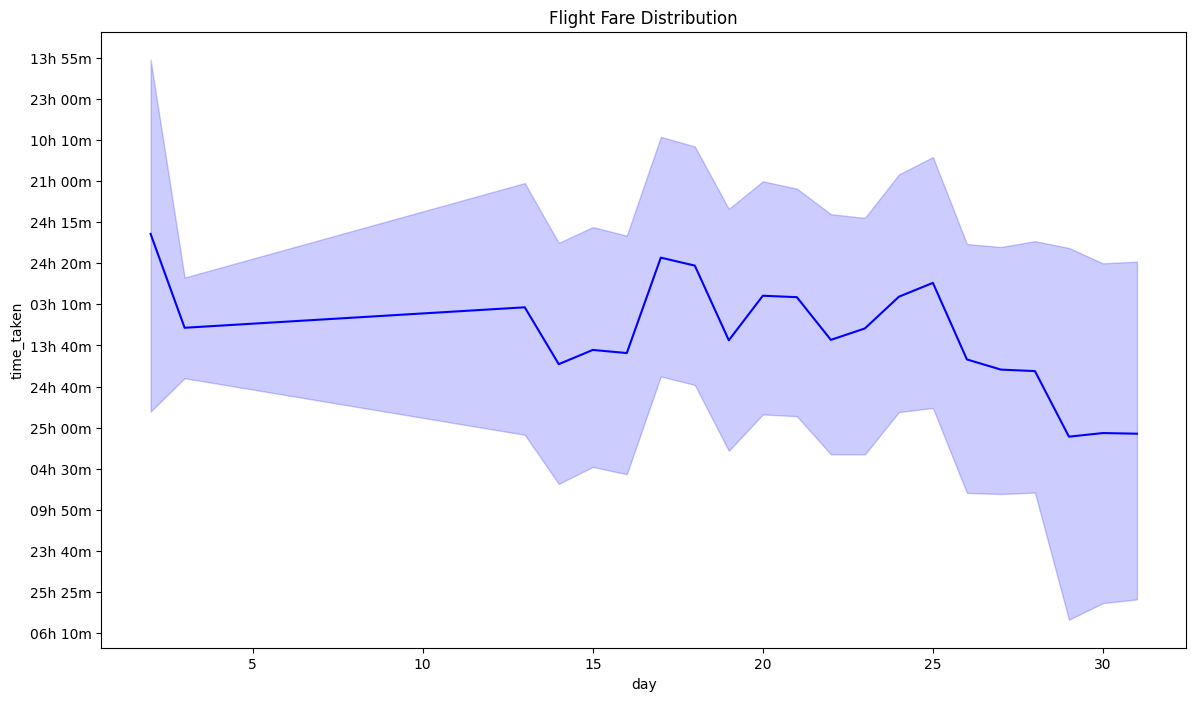

In [6]:
plt.figure(figsize=(14,8))  
plt.title("Flight Fare Distribution")
sns.lineplot(x="day", y="time_taken", data=dataset , color="blue")
plt.show()

In [7]:
dataset["dep_time"] = pd.to_datetime(dataset["dep_time"], format="%H:%M")

In [8]:
dataset["arr_time"] = pd.to_datetime(dataset["arr_time"], format="%H:%M")

In [9]:
dataset["time_taken"] = dataset["arr_time"] - dataset["dep_time"]
dataset["time_taken"] = dataset["time_taken"].dt.total_seconds()

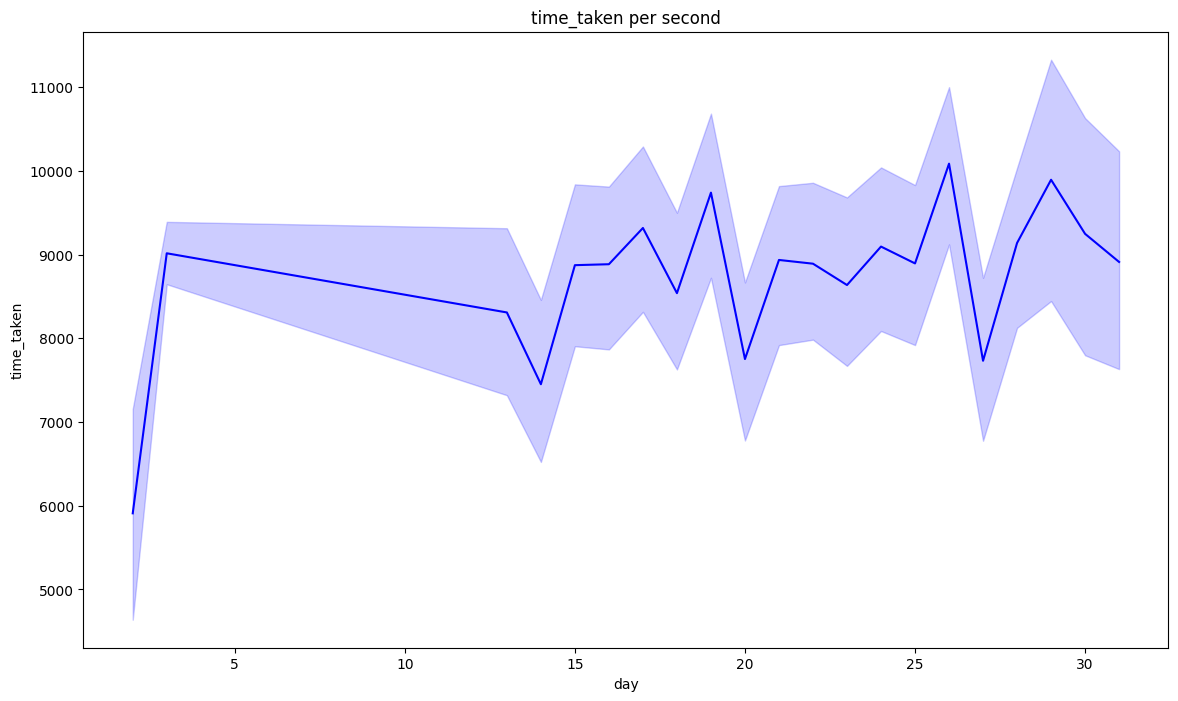

In [10]:
plt.figure(figsize=(14,8))  
plt.title("time_taken per second")
sns.lineplot(x="day", y="time_taken", data=dataset , color="blue")
plt.show()

In [11]:
dataset

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,month,year,day,dayofweek
0,2022-11-02,Air India,AI,868,1900-01-01 18:00:00,Delhi,7200.0,non-stop,1900-01-01 20:00:00,Mumbai,25612.0,11,2022,2,2
1,2022-11-02,Air India,AI,624,1900-01-01 19:00:00,Delhi,8100.0,non-stop,1900-01-01 21:15:00,Mumbai,25612.0,11,2022,2,2
2,2022-11-02,Air India,AI,531,1900-01-01 20:00:00,Delhi,2700.0,1-stop,1900-01-01 20:45:00,Mumbai,42220.0,11,2022,2,2
3,2022-11-02,Air India,AI,839,1900-01-01 21:25:00,Delhi,9000.0,1-stop,1900-01-01 23:55:00,Mumbai,44450.0,11,2022,2,2
4,2022-11-02,Air India,AI,544,1900-01-01 17:15:00,Delhi,24000.0,1-stop,1900-01-01 23:55:00,Mumbai,46690.0,11,2022,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93482,2022-03-31,Vistara,UK,822,1900-01-01 09:45:00,Chennai,36300.0,1-stop,1900-01-01 19:50:00,Hyderabad,69265.0,3,2022,31,3
93483,2022-03-31,Vistara,UK,826,1900-01-01 12:30:00,Chennai,37500.0,1-stop,1900-01-01 22:55:00,Hyderabad,77105.0,3,2022,31,3
93484,2022-03-31,Vistara,UK,832,1900-01-01 07:05:00,Chennai,49800.0,1-stop,1900-01-01 20:55:00,Hyderabad,79099.0,3,2022,31,3
93485,2022-03-31,Vistara,UK,828,1900-01-01 07:00:00,Chennai,36000.0,1-stop,1900-01-01 17:00:00,Hyderabad,81585.0,3,2022,31,3


In [12]:
dataset["time_taken"] = dataset["time_taken"] / 60
dataset["time_taken"] = dataset["time_taken"].astype(int)
dataset["dayofweek"] = dataset["dayofweek"].astype(int)
dataset["month"] = dataset["month"].astype(int)
dataset["year"] = dataset["year"].astype(int)
dataset["day"] = dataset["day"].astype(int)
dataset["price"] = dataset["price"].astype(np.float32)
dataset["num_code"] = dataset["num_code"].astype(object)

In [13]:
dataset.dtypes

date          datetime64[ns]
airline               object
ch_code               object
num_code              object
dep_time      datetime64[ns]
from                  object
time_taken             int64
stop                  object
arr_time      datetime64[ns]
to                    object
price                float32
month                  int64
year                   int64
day                    int64
dayofweek              int64
dtype: object

# FIND OUTLIERS

In [14]:
categorica_cols = dataset.select_dtypes(include=["object"]).columns
categorica_cols
numerical_cols = dataset.select_dtypes(exclude=["object", "datetime64"]).columns
numerical_cols

Index(['time_taken', 'price', 'month', 'year', 'day', 'dayofweek'], dtype='object')

In [15]:
LabelEncoder = LabelEncoder()
for column in categorica_cols:
    dataset[column] = LabelEncoder.fit_transform(dataset[column])
dataset.dtypes

date          datetime64[ns]
airline                int64
ch_code                int64
num_code               int64
dep_time      datetime64[ns]
from                   int64
time_taken             int64
stop                   int64
arr_time      datetime64[ns]
to                     int64
price                float32
month                  int64
year                   int64
day                    int64
dayofweek              int64
dtype: object

In [16]:
dataset

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,month,year,day,dayofweek
0,2022-11-02,0,0,214,1900-01-01 18:00:00,2,120,24,1900-01-01 20:00:00,5,25612.0,11,2022,2,2
1,2022-11-02,0,0,85,1900-01-01 19:00:00,2,135,24,1900-01-01 21:15:00,5,25612.0,11,2022,2,2
2,2022-11-02,0,0,50,1900-01-01 20:00:00,2,45,0,1900-01-01 20:45:00,5,42220.0,11,2022,2,2
3,2022-11-02,0,0,191,1900-01-01 21:25:00,2,150,0,1900-01-01 23:55:00,5,44450.0,11,2022,2,2
4,2022-11-02,0,0,58,1900-01-01 17:15:00,2,400,0,1900-01-01 23:55:00,5,46690.0,11,2022,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93482,2022-03-31,1,1,175,1900-01-01 09:45:00,1,605,0,1900-01-01 19:50:00,3,69265.0,3,2022,31,3
93483,2022-03-31,1,1,179,1900-01-01 12:30:00,1,625,0,1900-01-01 22:55:00,3,77105.0,3,2022,31,3
93484,2022-03-31,1,1,184,1900-01-01 07:05:00,1,830,0,1900-01-01 20:55:00,3,79099.0,3,2022,31,3
93485,2022-03-31,1,1,181,1900-01-01 07:00:00,1,600,0,1900-01-01 17:00:00,3,81585.0,3,2022,31,3


In [17]:
dataset.drop(["date", "dep_time", "arr_time"], axis=1, inplace=True)
dataset

,airline,ch_code,num_code,from,time_taken,stop,to,price,month,year,day,dayofweek
0,0,0,214,2,120,24,5,25612.0,11,2022,2,2
1,0,0,85,2,135,24,5,25612.0,11,2022,2,2
2,0,0,50,2,45,0,5,42220.0,11,2022,2,2
3,0,0,191,2,150,0,5,44450.0,11,2022,2,2
4,0,0,58,2,400,0,5,46690.0,11,2022,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
93482,1,1,175,1,605,0,3,69265.0,3,2022,31,3
93483,1,1,179,1,625,0,3,77105.0,3,2022,31,3
93484,1,1,184,1,830,0,3,79099.0,3,2022,31,3
93485,1,1,181,1,600,0,3,81585.0,3,2022,31,3


In [18]:
for data in dataset.columns:
    print(data, len(dataset[data].unique()))

airline 2
ch_code 2
num_code 264
from 6
time_taken 428
stop 25
to 6
price 2358
month 12
year 1
day 21
dayofweek 7


In [19]:

Q1 = dataset["price"].quantile(0.25)
Q3 = dataset["price"].quantile(0.75)
IQR = Q3 - Q1

outliers = (dataset["price"] < (Q1 - 1.5 * IQR)) | (dataset["price"] > (Q3 + 1.5 * IQR))

clean_dataset = dataset[~outliers]

print(clean_dataset.shape)
clean_dataset

(89837, 12)


,airline,ch_code,num_code,from,time_taken,stop,to,price,month,year,day,dayofweek
0,0,0,214,2,120,24,5,25612.0,11,2022,2,2
1,0,0,85,2,135,24,5,25612.0,11,2022,2,2
2,0,0,50,2,45,0,5,42220.0,11,2022,2,2
3,0,0,191,2,150,0,5,44450.0,11,2022,2,2
4,0,0,58,2,400,0,5,46690.0,11,2022,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
93482,1,1,175,1,605,0,3,69265.0,3,2022,31,3
93483,1,1,179,1,625,0,3,77105.0,3,2022,31,3
93484,1,1,184,1,830,0,3,79099.0,3,2022,31,3
93485,1,1,181,1,600,0,3,81585.0,3,2022,31,3


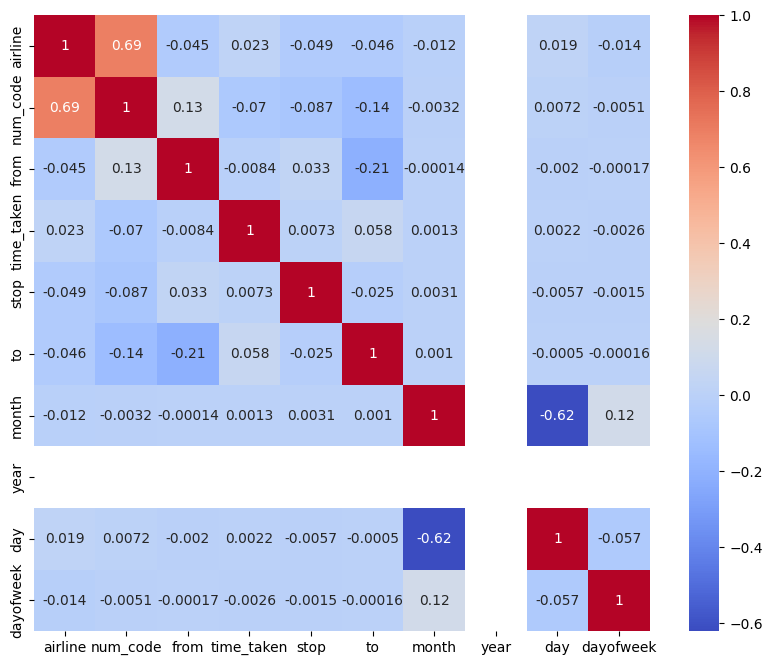

In [20]:
correlation = clean_dataset.drop(["price", "ch_code"], axis=1).corr() 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', square=True)
plt.show()

In [21]:
StandardScaler = StandardScaler()
numerical_cols = ['airline', 'ch_code', 'num_code', 'from', 'time_taken', 'stop', 'to', 'price', 'month', 'year']
clean_dataset_scaled =  StandardScaler.fit_transform(clean_dataset)
clean_dataset_scaled = pd.DataFrame(clean_dataset_scaled, columns=clean_dataset.columns)
clean_dataset_scaled

,airline,ch_code,num_code,from,time_taken,stop,to,price,month,year,day,dayofweek
0,-1.358280,-1.358280,0.752575,-0.315420,-0.052959,3.319244,1.388594,-2.414737,2.683274,0.0,-1.542498,-0.474917
1,-1.358280,-1.358280,-1.103948,-0.315420,-0.023848,3.319244,1.388594,-2.414737,2.683274,0.0,-1.542498,-0.474917
2,-1.358280,-1.358280,-1.607656,-0.315420,-0.198514,-0.327749,1.388594,-0.942657,2.683274,0.0,-1.542498,-0.474917
3,-1.358280,-1.358280,0.421567,-0.315420,0.005263,-0.327749,1.388594,-0.744997,2.683274,0.0,-1.542498,-0.474917
4,-1.358280,-1.358280,-1.492523,-0.315420,0.490445,-0.327749,1.388594,-0.546450,2.683274,0.0,-1.542498,-0.474917
...,...,...,...,...,...,...,...,...,...,...,...,...
89832,0.736225,0.736225,0.191301,-0.882625,0.888295,-0.327749,0.247903,1.454526,-0.268779,0.0,1.576923,0.010670
89833,0.736225,0.736225,0.248867,-0.882625,0.927109,-0.327749,0.247903,2.149438,-0.268779,0.0,1.576923,0.010670
89834,0.736225,0.736225,0.320826,-0.882625,1.324959,-0.327749,0.247903,2.326180,-0.268779,0.0,1.576923,0.010670
89835,0.736225,0.736225,0.277651,-0.882625,0.878591,-0.327749,0.247903,2.546531,-0.268779,0.0,1.576923,0.010670


In [22]:
clean_dataset_scaled

,airline,ch_code,num_code,from,time_taken,stop,to,price,month,year,day,dayofweek
0,-1.358280,-1.358280,0.752575,-0.315420,-0.052959,3.319244,1.388594,-2.414737,2.683274,0.0,-1.542498,-0.474917
1,-1.358280,-1.358280,-1.103948,-0.315420,-0.023848,3.319244,1.388594,-2.414737,2.683274,0.0,-1.542498,-0.474917
2,-1.358280,-1.358280,-1.607656,-0.315420,-0.198514,-0.327749,1.388594,-0.942657,2.683274,0.0,-1.542498,-0.474917
3,-1.358280,-1.358280,0.421567,-0.315420,0.005263,-0.327749,1.388594,-0.744997,2.683274,0.0,-1.542498,-0.474917
4,-1.358280,-1.358280,-1.492523,-0.315420,0.490445,-0.327749,1.388594,-0.546450,2.683274,0.0,-1.542498,-0.474917
...,...,...,...,...,...,...,...,...,...,...,...,...
89832,0.736225,0.736225,0.191301,-0.882625,0.888295,-0.327749,0.247903,1.454526,-0.268779,0.0,1.576923,0.010670
89833,0.736225,0.736225,0.248867,-0.882625,0.927109,-0.327749,0.247903,2.149438,-0.268779,0.0,1.576923,0.010670
89834,0.736225,0.736225,0.320826,-0.882625,1.324959,-0.327749,0.247903,2.326180,-0.268779,0.0,1.576923,0.010670
89835,0.736225,0.736225,0.277651,-0.882625,0.878591,-0.327749,0.247903,2.546531,-0.268779,0.0,1.576923,0.010670


In [23]:
clean_dataset_Prediction = clean_dataset_scaled.drop(["price", "ch_code"], axis=1)
clean_dataset_class = clean_dataset["price"]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(clean_dataset_Prediction, clean_dataset_class, test_size=0.2, random_state=42)

# Here are the top 10 machine learning models for regression tasks:

Note: The ranking is subjective and based on general popularity, performance, and versatility.

-Random Forest Regressor: A ensemble learning method that combines multiple decision trees to predict continuous outcomes.
-Gradient Boosting Regressor: A ensemble learning method that combines multiple weak models to create a strong predictive model.
-Support Vector Regressor (SVR): A kernel-based method that finds the best hyperplane to predict continuous outcomes.
-Linear Regression: A simple and widely used method for predicting continuous outcomes.
-Lasso Regression: A regularization technique that adds a penalty term to the loss function to prevent overfitting.
-Ridge Regression: A regularization technique that adds a penalty term to the loss function to prevent overfitting.
-Elastic Net Regression: A regularization technique that combines L1 and L2 penalties to prevent overfitting.
-XGBoost Regressor: A extreme gradient boosting method that is widely used for structured data.
-LightGBM Regressor: A fast and efficient gradient boosting method that is widely used for structured data.
-CatBoost Regressor: A gradient boosting method that is specifically designed for categorical data.

# Honorable mentions:

-Decision Tree Regressor: A simple and interpretable method for predicting continuous outcomes.
-K-Nearest Neighbors (KNN) Regressor: A simple and widely used method for predicting continuous outcomes.
-Neural Network Regressor: A deep learning method that uses multiple layers of interconnected nodes to predict continuous outcomes.

# Keep in mind:

The performance of a model depends on the specific dataset and task.
The choice of model depends on the complexity of the data, the size of the dataset, and the computational resources available.
It's always a good idea to try out multiple models and evaluate their performance using metrics such as mean squared error (MSE) or mean absolute error (MAE).
Regression metrics:

Mean Squared Error (MSE)
Mean Absolute Error (MAE)
Root Mean Squared Error (RMSE)
Coefficient of Determination (R-squared)
Mean Absolute Percentage Error (MAPE)

In [25]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'bootstrap': [True, False],
    'random_state': [42]
}

# Initialize the Random Forest Regressor
rf = RandomForestRegressor()

# Perform the grid search
grid_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, cv=5, scoring='neg_mean_squared_error' , error_score='raise', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Print the entire grid search results
print("Grid Search Results:")
print(grid_search.cv_results_)
  

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import mean_absolute_error


predict_rf = grid_search.predict(X_test)
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, predict_rf))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, predict_rf))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, predict_rf)))
print("R-squared:", r2_score(y_test, predict_rf))
print("Adjusted R-squared:", 1 - (1 - r2_score(y_test, predict_rf)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))
print("Mean Absolute Percentage Error (MAPE):", np.mean(np.abs((y_test - predict_rf) / y_test)) * 100)
print("------------------------------------------------------------------------------------------------------------")
print("Actual Values:", y_test)
print("Predicted Values:", predict_rf)  


new_row = {'Model Name' : 'Random Forest',
           'Mean_Absolute_Error_MAE' : mean_absolute_error(y_test, predict_rf),
           'Adj_R_Square' : 1 - (1 - r2_score(y_test, predict_rf)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1),
           'Mean_Absolute_Percentage_Error_MAPE' : np.mean(np.abs((y_test - predict_rf) / y_test)) * 100}



Mean Absolute Error (MAE): 1783.0065908436743
Mean Squared Error (MSE): 12118937.571932847
Root Mean Squared Error (RMSE): 3481.226446517498
R-squared: 0.9058294597893405
Adjusted R-squared: 0.9057770175438593
Mean Absolute Percentage Error (MAPE): 3.167813124266254
------------------------------------------------------------------------------------------------------------
Actual Values: 31066    62045.0
82405    57920.0
11248    53209.0
39908    39847.0
82317    27792.0
          ...   
74854    56590.0
71945    58315.0
70237    47586.0
56102    32881.0
4380     50969.0
Name: price, Length: 17968, dtype: float32
Predicted Values: [64627.18638961 57746.80694949 54108.16756133 ... 47683.78316628
 33020.05583333 50969.        ]


In [ ]:
models_df = pd.DataFrame(columns=['Model Name',
    'Mean_Absolute_Error_MAE',
    'Adj_R_Square',
    'Mean_Absolute_Percentage_Error_MAPE',
  ])
models_df = pd.concat([models_df])

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_depth': [3, 5, 7, 9, 11],
    'learning_rate': [0.1, 0.01, 0.001],
    'loss': ['squared_error', 'huber', 'quantile', 'absolute_error'],
    'random_state': [42]
}

# Initialize the Gradient Boosting Regressor
gbr = GradientBoostingRegressor()

# Perform the grid search 
grid_search = RandomizedSearchCV(estimator=gbr, param_distributions=param_grid, cv=5, scoring='neg_mean_squared_error' , error_score='raise', n_jobs=-1)
#grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Print the entire grid search results
print("Grid Search Results:")
print(grid_search.cv_results_)

Best Parameters: {'random_state': 42, 'n_estimators': 200, 'max_depth': 9, 'loss': 'absolute_error', 'learning_rate': 0.1}
Best Score: -19098036.31618929
Grid Search Results:
{'mean_fit_time': array([ 5.32715392,  4.39410739, 25.84846053, 56.44796638, 42.47364817,
       53.98006573,  0.70826836,  2.78137102, 69.79654741, 38.09761052]), 'std_fit_time': array([0.4024825 , 0.36525255, 1.89768867, 1.62787866, 3.6553393 ,
       2.10702015, 0.00866109, 0.44251585, 0.57515974, 1.82448615]), 'mean_score_time': array([0.01990547, 0.02140584, 0.20465193, 0.28208098, 0.22097902,
       0.23355131, 0.00691361, 0.01779175, 0.22722573, 0.12905922]), 'std_score_time': array([0.00068023, 0.00228066, 0.05008103, 0.057624  , 0.01331493,
       0.0180374 , 0.00036876, 0.00201524, 0.02158766, 0.01069006]), 'param_random_state': masked_array(data=[42, 42, 42, 42, 42, 42, 42, 42, 42, 42],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fi

In [ ]:
predict_gbr = grid_search.predict(X_test)
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, predict_gbr))    
print("Mean Squared Error (MSE):", mean_squared_error(y_test, predict_gbr))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, predict_gbr)))
print("R-squared:", r2_score(y_test, predict_gbr))
print("Adjusted R-squared:", 1 - (1 - r2_score(y_test, predict_gbr)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))
print("Mean Absolute Percentage Error (MAPE):", np.mean(np.abs((y_test - predict_gbr) / y_test)) * 100)
print("------------------------------------------------------------------------------------------------------------")
print("Actual Values:", y_test)
print("Predicted Values:", predict_gbr)


new_row = {'Model Name' : 'Gradient Boosting',
           'Mean_Absolute_Error_MAE' : mean_absolute_error(y_test, predict_gbr),           
           'Adj_R_Square' : 1 - (1 - r2_score(y_test, predict_gbr)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1),
           'Mean_Absolute_Percentage_Error_MAPE' : np.mean(np.abs((y_test - predict_gbr) / y_test)) * 100}



Mean Absolute Error (MAE): 1935.8053942466825
Mean Squared Error (MSE): 18280828.219176494
Root Mean Squared Error (RMSE): 4275.608520336783
R-squared: 0.8579483177729123
Adjusted R-squared: 0.8578692111948496
Mean Absolute Percentage Error (MAPE): 3.468232367533401
------------------------------------------------------------------------------------------------------------
Actual Values: 31066    62045.0
82405    57920.0
11248    53209.0
39908    39847.0
82317    27792.0
          ...   
74854    56590.0
71945    58315.0
70237    47586.0
56102    32881.0
4380     50969.0
Name: price, Length: 17968, dtype: float32
Predicted Values: [61766.42983419 58474.36376612 53380.75972737 ... 47588.26668381
 49082.08944785 50507.24101823]


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4],
    'epsilon': [0.1, 0.01, 0.001],
}

# Initialize the SVR
svr = SVR()

# Perform the grid search 
grid_search = RandomizedSearchCV(estimator=svr, param_distributions=param_grid, cv=5, scoring='neg_mean_squared_error' , error_score='raise', n_jobs=-1)

#grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Print the entire grid search results
print("Grid Search Results:")
print(grid_search.cv_results_)

Best Parameters: {'kernel': 'rbf', 'gamma': 'auto', 'epsilon': 0.001, 'degree': 3, 'C': 1000}
Best Score: -71506151.50377008
Grid Search Results:
{'mean_fit_time': array([278.87654071, 287.13841228, 519.35959525, 319.41638589,
       222.85103302, 269.92307324, 275.70322847, 252.93904562,
       342.07961979, 191.67231832]), 'std_fit_time': array([ 24.6297424 ,  44.08731636, 117.33973244,  19.94762698,
        36.6160429 ,  24.53615366,  41.26685198,  21.71713072,
        29.25158174,  15.68639781]), 'mean_score_time': array([ 26.64361372,  36.15915413,  44.97398186, 100.06826301,
        30.12768846,  38.90896688,  27.50974874,  73.1225286 ,
        15.84295993,  12.84996214]), 'std_score_time': array([ 6.54155741,  4.80776532, 11.93219375,  5.7500874 ,  5.61541435,
       10.59365726,  5.72217991,  9.68188336,  1.81433525,  1.84626854]), 'param_kernel': masked_array(data=['linear', 'sigmoid', 'sigmoid', 'rbf', 'linear',
                   'poly', 'poly', 'rbf', 'sigmoid', 'linear'],


In [ ]:
predict_svr = grid_search.predict(X_test)    
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, predict_svr))    
print("Mean Squared Error (MSE):", mean_squared_error(y_test, predict_svr))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, predict_svr)))
print("R-squared:", r2_score(y_test, predict_svr))
print("Adjusted R-squared:", 1 - (1 - r2_score(y_test, predict_svr)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))
print("Mean Absolute Percentage Error (MAPE):", np.mean(np.abs((y_test - predict_svr) / y_test)) * 100)
print("------------------------------------------------------------------------------------------------------------")
print("Actual Values:", y_test)
print("Predicted Values:", predict_svr)

new_row = {'Model Name' : 'Support Vector Regression',
           'Mean_Absolute_Error_MAE' : mean_absolute_error(y_test, predict_svr),           
           'Adj_R_Square' : 1 - (1 - r2_score(y_test, predict_svr)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1),
           'Mean_Absolute_Percentage_Error_MAPE' : np.mean(np.abs((y_test - predict_svr) / y_test)) * 100}



Mean Absolute Error (MAE): 5898.339106868712
Mean Squared Error (MSE): 69749051.35574593
Root Mean Squared Error (RMSE): 8351.589750206
R-squared: 0.45801306373888284
Adjusted R-squared: 0.4577112388593032
Mean Absolute Percentage Error (MAPE): 11.804135053626586
------------------------------------------------------------------------------------------------------------
Actual Values: 31066    62045.0
82405    57920.0
11248    53209.0
39908    39847.0
82317    27792.0
          ...   
74854    56590.0
71945    58315.0
70237    47586.0
56102    32881.0
4380     50969.0
Name: price, Length: 17968, dtype: float32
Predicted Values: [59842.42061596 53053.9203004  46620.97373753 ... 47949.86958352
 47439.60216978 45975.51799774]


TypeError: cannot concatenate object of type '<class 'dict'>'; only Series and DataFrame objs are valid

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

# Define the parameter grid
param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'n_jobs': [1, 2, 4],
    'positive': [True, False],

}

# Initialize the Linear Regression
lr = LinearRegression()

# Perform the grid search
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score


GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False], 'n_jobs': [1, 2, 4],
                         'positive': [True, False]},
             scoring='neg_mean_squared_error')

In [ ]:
predict_lr = grid_search.predict(X_test)    
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, predict_lr))    
print("Mean Squared Error (MSE):", mean_squared_error(y_test, predict_lr))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, predict_lr)))
print("R-squared:", r2_score(y_test, predict_lr))
print("Adjusted R-squared:", 1 - (1 - r2_score(y_test, predict_lr)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))
print("Mean Absolute Percentage Error (MAPE):", np.mean(np.abs((y_test - predict_lr) / y_test)) * 100)
print("------------------------------------------------------------------------------------------------------------")
print("Actual Values:", y_test)
print("Predicted Values:", predict_lr)

new_row = {'Model Name' : 'Linear Regression',
           'Mean_Absolute_Error_MAE' : mean_absolute_error(y_test, predict_lr),           
           'Adj_R_Square' : 1 - (1 - r2_score(y_test, predict_lr)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1),
           'Mean_Absolute_Percentage_Error_MAPE' : np.mean(np.abs((y_test - predict_lr) / y_test)) * 100}


Mean Absolute Error (MAE): 7421.355818766509
Mean Squared Error (MSE): 90011312.84246592
Root Mean Squared Error (RMSE): 9487.42920091981
R-squared: 0.30056459940210845
Adjusted R-squared: 0.3001750936936951
Mean Absolute Percentage Error (MAPE): 15.25922263253387
------------------------------------------------------------------------------------------------------------
Actual Values: 31066    62045.0
82405    57920.0
11248    53209.0
39908    39847.0
82317    27792.0
          ...   
74854    56590.0
71945    58315.0
70237    47586.0
56102    32881.0
4380     50969.0
Name: price, Length: 17968, dtype: float32
Predicted Values: [58199.75687829 56960.92320356 50993.61464495 ... 50804.74951045
 50990.40662737 50228.96333023]


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

# Define the parameter grid
param_grid = {
    'alpha': [0.1, 0.5, 1, 5, 10],
    'fit_intercept': [True, False],
    'max_iter': [1000, 2000, 5000],
    'tol': [0.001, 0.01, 0.1],

}

# Initialize the Lasso Regression
lasso = Lasso()

# Perform the grid search
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Print the entire grid search results
print("Grid Search Results:")
print(grid_search.cv_results_)

Best Parameters: {'alpha': 0.1, 'fit_intercept': True, 'max_iter': 1000, 'tol': 0.1}
Best Score: -90304744.15562925
Grid Search Results:
{'mean_fit_time': array([0.06182537, 0.05635066, 0.06077185, 0.05451865, 0.03466315,
       0.02277799, 0.02476888, 0.02777781, 0.0210813 , 0.01925488,
       0.0174417 , 0.01637921, 0.01642437, 0.01873193, 0.02255125,
       0.01984916, 0.0183876 , 0.01665778, 0.01648817, 0.01761732,
       0.01659651, 0.0179235 , 0.01823139, 0.01729937, 0.01831498,
       0.01861892, 0.01626897, 0.01685033, 0.01550765, 0.01472945,
       0.01639757, 0.0162169 , 0.0158299 , 0.01581626, 0.01554394,
       0.01661568, 0.01773758, 0.01724696, 0.01499195, 0.01672912,
       0.01704168, 0.01665182, 0.01854224, 0.01926746, 0.02026801,
       0.0165556 , 0.01644211, 0.01630445, 0.01751003, 0.01685853,
       0.01659589, 0.01793518, 0.01454105, 0.01721673, 0.01617208,
       0.01614962, 0.01514854, 0.01688042, 0.01633396, 0.01481509,
       0.01835346, 0.01613288, 0.01447453

In [ ]:
predict_lasso = grid_search.predict(X_test)    
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, predict_lasso))    
print("Mean Squared Error (MSE):", mean_squared_error(y_test, predict_lasso))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, predict_lasso)))
print("R-squared:", r2_score(y_test, predict_lasso))
print("Adjusted R-squared:", 1 - (1 - r2_score(y_test, predict_lasso)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))
print("Mean Absolute Percentage Error (MAPE):", np.mean(np.abs((y_test - predict_lasso) / y_test)) * 100)
print("------------------------------------------------------------------------------------------------------------")
print("Actual Values:", y_test)
print("Predicted Values:", predict_lasso)

Mean Absolute Error (MAE): 7421.3591283730475
Mean Squared Error (MSE): 90011313.54637554
Root Mean Squared Error (RMSE): 9487.429238016774
R-squared: 0.30056459393235935
Adjusted R-squared: 0.3001750882208999
Mean Absolute Percentage Error (MAPE): 15.259249661544919
------------------------------------------------------------------------------------------------------------
Actual Values: 31066    62045.0
82405    57920.0
11248    53209.0
39908    39847.0
82317    27792.0
          ...   
74854    56590.0
71945    58315.0
70237    47586.0
56102    32881.0
4380     50969.0
Name: price, Length: 17968, dtype: float32
Predicted Values: [58199.88926572 56960.84539459 50993.79810815 ... 50804.62894043
 50991.0775393  50229.02555306]


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# Define the parameter grid
param_grid = {
    'alpha': [0.1, 0.5, 1, 5, 10],
    'fit_intercept': [True, False],
    'max_iter': [1000, 2000, 5000],
    'tol': [0.001, 0.01, 0.1],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
   
}

# Initialize the Ridge Regression
ridge = Ridge()

# Perform the grid search
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Print the entire grid search results
print("Grid Search Results:")
print(grid_search.cv_results_)

c:\Users\lucas\Desktop\COURSES\SCIENCE_PROJECTS\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'alpha': 5, 'fit_intercept': True, 'max_iter': 1000, 'solver': 'sag', 'tol': 0.01}
Best Score: -90300864.35324168
Grid Search Results:
{'mean_fit_time': array([0.01093702, 0.0102685 , 0.0108737 , 0.02515879, 0.02342472,
       0.0220346 , 0.01168737, 0.00970993, 0.0089251 , 0.0160182 ,
       0.01487513, 0.01133032, 0.01101007, 0.00986385, 0.00916333,
       0.74358473, 0.56388268, 0.27325726, 0.45631385, 0.32649317,
       0.21466074, 0.01670628, 0.01621838, 0.01794629, 0.05739055,
       0.04237032, 0.04287615, 0.02280641, 0.01852798, 0.01927643,
       0.02451558, 0.02808857, 0.0249516 , 0.02096243, 0.0246696 ,
       0.02225909, 0.82664022, 0.51221857, 0.3288764 , 0.44194093,
       0.31725316, 0.14113369, 0.0148129 , 0.01509619, 0.01531157,
       0.04344087, 0.03394437, 0.03493443, 0.01829786, 0.01711812,
       0.01915212, 0.02728944, 0.02510295, 0.02127466, 0.01878538,
       0.01588602, 0.01474442, 0.7590003 , 0.55993247, 0.28109293,
       0.45709748, 0.2791

In [ ]:
predict_ridge = grid_search.predict(X_test)    
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, predict_ridge))    
print("Mean Squared Error (MSE):", mean_squared_error(y_test, predict_ridge))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, predict_ridge)))     
print("R-squared:", r2_score(y_test, predict_ridge))
print("Adjusted R-squared:", 1 - (1 - r2_score(y_test, predict_ridge)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))
print("Mean Absolute Percentage Error (MAPE):", np.mean(np.abs((y_test - predict_ridge) / y_test)) * 100)
print("------------------------------------------------------------------------------------------------------------")
print("Actual Values:", y_test)
print("Predicted Values:", predict_ridge)

Mean Absolute Error (MAE): 7421.355818766509
Mean Squared Error (MSE): 90011312.84246592
Root Mean Squared Error (RMSE): 9487.42920091981
R-squared: 0.30056459940210845
Adjusted R-squared: 0.3001750936936951
Mean Absolute Percentage Error (MAPE): 15.25922263253387
------------------------------------------------------------------------------------------------------------
Actual Values: 31066    62045.0
82405    57920.0
11248    53209.0
39908    39847.0
82317    27792.0
          ...   
74854    56590.0
71945    58315.0
70237    47586.0
56102    32881.0
4380     50969.0
Name: price, Length: 17968, dtype: float32
Predicted Values: [58199.75687829 56960.92320356 50993.61464495 ... 50804.74951045
 50990.40662737 50228.96333023]


In [ ]:
import random
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

# Define the parameter grid
param_grid = {
    'alpha': [0.1, 0.5, 1, 5, 10],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1],
    'fit_intercept': [True, False],
    'max_iter': [1000, 2000, 5000],
    'tol': [0.001, 0.01, 0.1],
}

# Initialize the Elastic Net Regression
en = ElasticNet()

# Perform the grid search
random_search = RandomizedSearchCV(estimator=en, param_distributions=param_grid, cv=5, scoring='neg_mean_squared_error', n_iter=10, n_jobs=-1)
#grid_search = GridSearchCV(estimator=en, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
random_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

# Print the entire grid search results
print("Grid Search Results:")
print(random_search.cv_results_)

Best Parameters: {'tol': 0.01, 'max_iter': 5000, 'l1_ratio': 1, 'fit_intercept': True, 'alpha': 0.5}
Best Score: -90304748.99659082
Grid Search Results:
{'mean_fit_time': array([0.05784168, 0.07438316, 0.05191855, 0.06289072, 0.02434106,
       0.02665949, 0.023206  , 0.01537485, 0.01323075, 0.01437807]), 'std_fit_time': array([0.01767674, 0.01780353, 0.00970546, 0.00877469, 0.00305192,
       0.00393161, 0.00487797, 0.00259841, 0.00121814, 0.00166325]), 'mean_score_time': array([0.00339851, 0.00283728, 0.00440512, 0.00351028, 0.00210762,
       0.00238328, 0.00231524, 0.00168271, 0.00170059, 0.0014688 ]), 'std_score_time': array([0.00079979, 0.00092193, 0.00166069, 0.00063616, 0.00073783,
       0.0004338 , 0.00054369, 0.00051046, 0.00015281, 0.00040768]), 'param_tol': masked_array(data=[0.1, 0.01, 0.01, 0.001, 0.001, 0.1, 0.1, 0.1, 0.1,
                   0.01],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_va

In [ ]:
predict_en = random_search.predict(X_test)    
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, predict_en))    
print("Mean Squared Error (MSE):", mean_squared_error(y_test, predict_en))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_test, predict_en)))     
print("R-squared:", r2_score(y_test, predict_en))
print("Adjusted R-squared:", 1 - (1 - r2_score(y_test, predict_en)) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1))
print("Mean Absolute Percentage Error (MAPE):", np.mean(np.abs((y_test - predict_en) / y_test)) * 100)
print("------------------------------------------------------------------------------------------------------------")
print("Actual Values:", y_test)
print("Predicted Values:", predict_en)

Mean Absolute Error (MAE): 7421.37014749056
Mean Squared Error (MSE): 90011301.24422234
Root Mean Squared Error (RMSE): 9487.428589677096
R-squared: 0.30056468952658166
Adjusted R-squared: 0.3001751838683573
Mean Absolute Percentage Error (MAPE): 15.259357377094581
------------------------------------------------------------------------------------------------------------
Actual Values: 31066    62045.0
82405    57920.0
11248    53209.0
39908    39847.0
82317    27792.0
          ...   
74854    56590.0
71945    58315.0
70237    47586.0
56102    32881.0
4380     50969.0
Name: price, Length: 17968, dtype: float32
Predicted Values: [58200.43687452 56960.71365504 50994.06627162 ... 50804.03071539
 50993.26902988 50229.14741222]


In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 9, 11],
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'n_estimators': [50, 100, 200, 500],
    'gamma': [0, 0.1, 0.5, 1],
    'subsample': [0.5, 0.8, 1],
    'colsample_bytree': [0.5, 0.8, 1],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

# Initialize the XGBoost Regressor
xgb_regressor = xgb.XGBRegressor()

# Perform the grid search
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Print the entire grid search results
print("Grid Search Results:")
print(grid_search.cv_results_)

In [ ]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

# Define the parameter grid
param_grid = {
    'num_leaves': [31, 62, 127],
    'max_depth': [-1, 5, 10],
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'min_data_in_leaf': [10, 50, 100],
    'min_sum_hessian_in_leaf': [0.001, 0.01, 0.1],
    'feature_fraction': [0.5, 0.8, 1],
    'bagging_fraction': [0.5, 0.8, 1],
    'bagging_freq': [5, 10, 20],
    'lambda_l1': [0, 0.1, 0.5],
    'lambda_l2': [0, 0.1, 0.5]
}

# Initialize the LightGBM Regressor
lgb_regressor = lgb.LGBMRegressor()

# Perform the grid search
grid_search = GridSearchCV(estimator=lgb_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Print the entire grid search results
print("Grid Search Results:")
print(grid_search.cv_results_)

In [ ]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

# Define the parameter grid
param_grid = {
    'depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'l2_leaf_reg': [0, 0.1, 0.5],
    'iterations': [50, 100, 200],
    'random_state': [42],
    'task_type': ['GPU', 'CPU'],
    'border_count': [32, 64, 128],
    'boosting_type': ['Ordered', 'Plain']
}

# Initialize the CatBoost Regressor
catboost_regressor = CatBoostRegressor()

# Perform the grid search
grid_search = GridSearchCV(estimator=catboost_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Print the entire grid search results
print("Grid Search Results:")
print(grid_search.cv_results_)